# <ins>**Travaux pratique 1**</ins>
## <ins>Parcours des protons dans la matière</ins>
Importation de Modules utiles et définitions de certains termes.

In [1]:
from scipy.constants import Avogadro, c, m_e, m_p, e, physical_constants
from pandas.plotting import table
from functools import partial, lru_cache
import csv
import scipy.integrate as integrate
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

eV_to_MeV = 1e-6            #Convertion eV vers MeV.

m_p = m_p  * eV_to_MeV/e    # Masse du proton en MeV/c^2
m_e = m_e  * eV_to_MeV/e    # Masse de l'électron en MeV/c^2

r_e = physical_constants["classical electron radius"][0] * 1e2      # cm

KeyboardInterrupt: 

<hr style="border-color:#D4D4D4">

## ***Question 1***
Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

-------------VÉRIFIÉ_AVEC_AUTRE_ÉQUIPE_C'EST_GOOD--------------

In [84]:
n_e = lambda atomic_numbers, fractions_by_weight, rho, A: rho * Avogadro * np.sum(atomic_numbers * fractions_by_weight/A)

I_bone = 91.9 * eV_to_MeV                                                                                               # Mean Excitation Energy en MeV de l'eau liquide.
rho_bone = 1.85                                                                                                         # Densité de l'os Compact en g/cm^3
atomic_numbers_bone = np.array([1, 6, 7, 8, 12, 15, 16, 20])                                                            # Nombre atomique.
fractions_by_weight_bone = np.array([0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000])   # Fractions Massiques.
AtomicMasses_bone = np.array([1.007975, 12.0106, 14.006855, 15.99940, 24.3055, 30.973762, 32.0675, 40.078])             # Masses Atomiques.

n_e_bone = n_e(atomic_numbers_bone, fractions_by_weight_bone, rho_bone, AtomicMasses_bone)                              # Densité électronique de l'Os Compact

I_water = 75 * eV_to_MeV                                                                                                # Mean Excitation Energy en MeV de l'eau liquide.
rho_water = 1                                                                                                           # Densité de l'eau liquide en g/cm^3
atomic_numbers_water = np.array([1, 8])                                                                                 # Nombre atomique.
fractions_by_weight_water = np.array([0.111894, 0.888106])                                                              # Fractions Massiques.
AtomicMasses_water = np.array([1.008, 15.999])                                                                          # Masses Atomiques.

n_e_water = n_e(atomic_numbers_water, fractions_by_weight_water, rho_water, AtomicMasses_water)                         # Densité électronique de l'eau liquide

print(f"Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de {n_e_bone} e-/cm\u00b3 et {n_e_water} e-/cm\u00b3.")

Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de 5.905891191511755e+23 e-/cm³ et 3.342810286137214e+23 e-/cm³.


<hr style="border-color:#D4D4D4">

## ***Question 2***
**<span style="color:#0C4504"><ins>Vérifié avec autre équipe, c'est good</ins></span>**

L’approximation d’une décélération continue (Continuous Slowing Down Approximation, CSDA) des protons dans la matière, en ligne droite, permet d’estimer leur portée dans le milieu considéré (la distance qu’ils peuvent parcourir avant d’avoir transféré au milieu la totalité de leur énergie cinétique initiale). Ici, seuls les transferts d’énergie vers les électrons du milieu sont considérés.

**Équation 9 :**
$$
T = (\gamma - 1) m_p c^2 \Rightarrow \gamma = \frac{T}{m_p c^2} + 1
$$
**Équation 10 :**
$$
\gamma = \frac{1}{\sqrt{1 - \beta^2}} \Rightarrow \gamma^2 \beta^2 = (\gamma^2 - 1)
$$


Certaines Équations sont utiles afin de faire ce problème :

**Équation 3:**
$$
T_e^{max} = \frac{2 m_e c^2 (\gamma^2 - 1)}{1 + 2 \gamma \frac{m_e}{m_p} + \left( \frac{m_e}{m_p} \right)^2}
$$
**Équation 4:**
$$
S_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \big[\ln\big(\frac{2 m_e c^2 \beta^2 \lambda^2 T_e^{max}}{I^2}\big) - 2 \beta^2\big]
$$


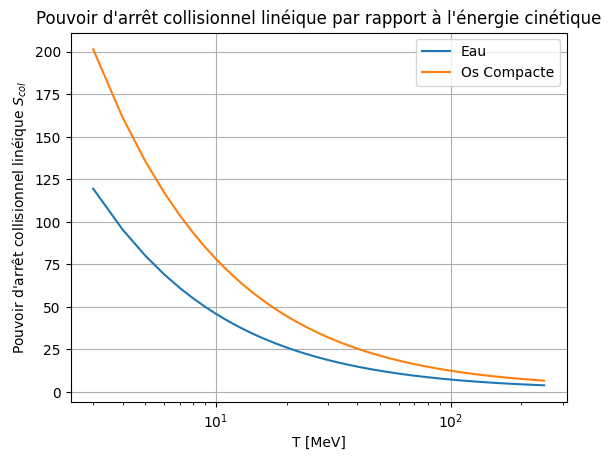

In [85]:
def gamma(T):   # Implémentation de l'équation 9.
    gamma = T/(m_p*c**2) + 1
    return gamma

def beta(T):    # implémentation de l'équation 10.
    beta = np.sqrt((gamma(T)**2 - 1)/gamma(T)**2)
    return beta

def t_max(T):   # implémentation de l'équation 3.
    t_max = (2*m_e*c**2 * (gamma(T)**2 - 1))/(1 + 2*(m_e/m_p)*gamma(T) + (m_e/m_p)**2)
    return t_max

def s_col(T, n_e, I_MeV):   # implémentation de l'équation 4.
    constant = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    s_col = constant * (1/beta(T)**2) * (np.log(2*m_e*c**2*beta(T)**2*t_max(T)/I_MeV**2) - 2*beta(T)**2)
    return s_col

SCol_bone = partial(s_col, n_e=n_e_bone, I_MeV=I_bone)      # définition du pouvoir d'arrêt collisionnel pour l'os compact.

SCol_water = partial(s_col, n_e=n_e_water, I_MeV=I_water)   # définition du pouvoir d'arrêt collisionnel pour l'eau liquide.

T = np.linspace(3, 250, 248)
S_col_water = SCol_water(T)     # Calcul du pouvoir d'arrêt collisionnel pour l'eau liquide.
S_col_bone = SCol_bone(T)       # Calcul du pouvoir d'arrêt collisionnel pour l'os compact.

#print(f"Kinetic energy T: {T}")
#print(f"Stopping Power S_col_bone: {S_col_bone} MeV/cm")
#print(f"Stopping Power S_col_water: {S_col_water} MeV/cm")
def plotit(T, bone=S_col_bone, water=S_col_water):      # Mise en graphique des pouvoirs d'arrêts.
    plt.plot(T, water, label="Eau")  # Tracé normal (pas semi-log sur X)
    plt.plot(T, bone, label="Os Compacte")
    plt.title("Pouvoir d'arrêt collisionnel linéique par rapport à l'énergie cinétique")  # Titre du graphique
    plt.xlabel("T [MeV]")
    plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
    plt.xscale('log')  # Axe des y en échelle logarithmique
    plt.legend()
    plt.grid()
    plt.show()

plotit(T)

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Portée des protons dans la matière**
## ***Question 3***
Les données PSTAR sont données ici : https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.
### <ins>Pour l'eau liquide:</ins>

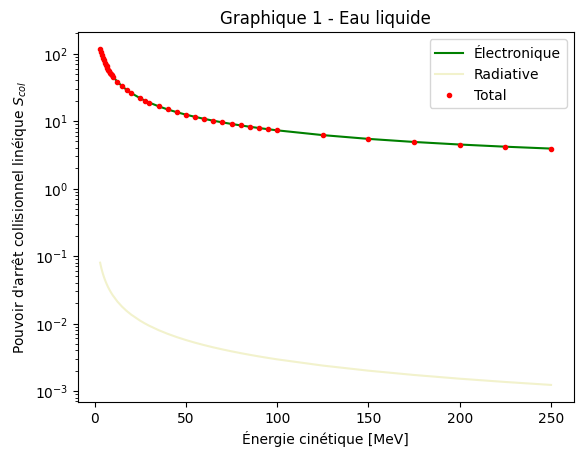

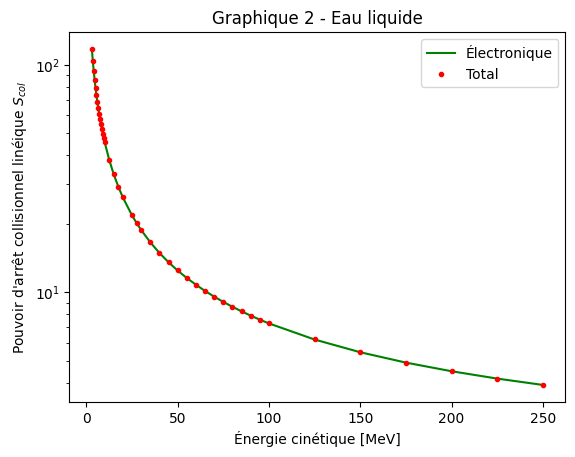

In [101]:
Ke_Mev_eau_liquide, \
Stopping_power_Electronic_eau_liquide, \
Stopping_power_Nuclear_eau_liquide, \
Stopping_power_total_eau_liquide = np.loadtxt("data_eau_liquide.txt", unpack=True)


plt.title("Graphique 1 - Eau liquide")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide,'g',label="Électronique")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Nuclear_eau_liquide, 'y', alpha=0.2,label="Radiative")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Total")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
plt.legend()
plt.show()

plt.title("Graphique 2 - Eau liquide")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide, 'g',label="Électronique")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Total")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
plt.legend()
plt.show()


### <ins>Pour l'os compact:</ins>

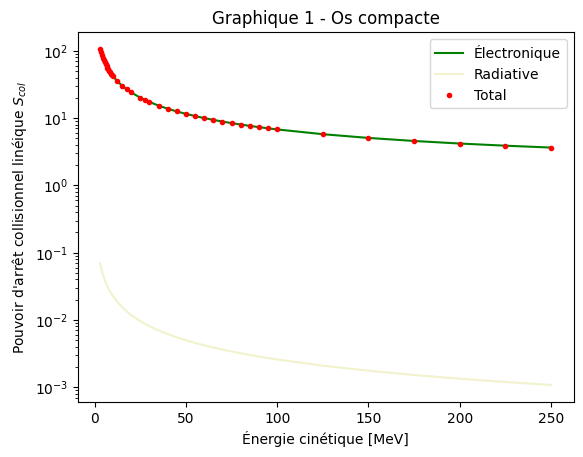

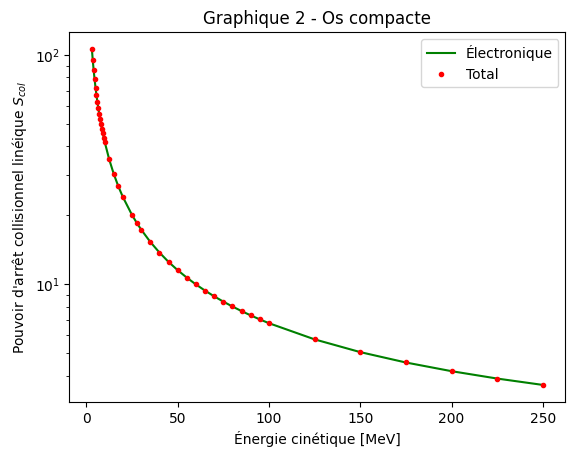

In [102]:
Ke_Mev_os_compact , \
Stopping_power_Electronic_os_compact, \
Stopping_power_Nuclear_os_compact, \
Stopping_power_total_os_compact = np.loadtxt("data_os_compact.txt", unpack=True)

plt.title("Graphique 1 - Os compacte")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact,'g',label="Électronique")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Nuclear_os_compact, 'y', alpha=0.2,label="Radiative")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Total")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
plt.legend()
plt.show()

plt.title("Graphique 2 - Os compacte")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact, 'g',label="Électronique")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Total")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
plt.legend()
plt.show()

Il est possible de voir qu'il n'est pas nécessaire de considérer la contribution radiative. 

En effet, sa contribution est très minime comme on le voit aux Graphiques 1. Ces derniers montres les contributions des interactions nucléaires (Électroniques), les contributions radiatives, ainsi que le stopping power total. On remarque aux Graphiques 2 que le stopping power total et la contribution électronique sont presque identique. Cela prouve que la contribution radiative est négligeable. 

<hr style="border-color:#D4D4D4">

## ***Question 4***

À partir de l'équation suivante 
$ 
\frac{S_{col}}{\rho} = - \left( \frac{1}{\rho} \frac{dT}{dx} \right)_{col} 
$
on peut réexprimer dx en fonction du reste,
$$
dx = -\frac{dT}{S_{col}}
$$
On obtient ensuite,
$$ 
x = -\int^{T_i}_0 \frac{dT}{S_{col}}
$$

En prenant l'inverse du pouvoir d'arrêt, cela nous permet d'avoir les unités de longueurs par rapport de l'énergie. On intègre ensuite sur ces unités de longueurs pour obtenir l'entièreté de la porté.


<hr style="border-color:#D4D4D4">

## ***Question 5***


### **<span style="color:#700009"><ins>À améliorer:</ins></span>**
Équation complexe, il n’existe pas de solution analytique générale permettant de relier directement l’énergie initiale d’un proton à sa portée dans un milieu donné. $\frac{1}{\ln(x)}$ ne s'intègre pas.

<hr style="border-color:#D4D4D4">

## ***Question 6***

In [ ]:
@np.vectorize
@lru_cache(maxsize=None)
def inverse_scol_water(T):
    return 1/SCol_water(T)

@np.vectorize
@lru_cache(maxsize=None)
def inverse_scol_bone(T):
    return 1/SCol_bone(T)

def inverse(func):
    def wrapper(*args):
        res = func(*args)
        return 1/res
    return wrapper

def n_valeurs():
    puissance_de_2 = [2**i for i in range(1, 27)]
    return puissance_de_2

Trapèze

In [ ]:
def trapeze(water_bone, a, b, n_valeurs, tol=np.finfo(float).eps):

    # Initialisation des listes pour stocker les résultats
    n_liste = []  # Liste des valeurs de N
    i_liste = []  # Liste des valeurs d'I (approximations successives)
    erreurs_liste = []  # Liste des erreurs entre I_i et I_{i-1}

    I_avant = None  # Initialisation de la variable pour stocker les résultats précédents

    for N in n_valeurs:  # Parcourir les valeurs de N
        h = (b - a) / N

        # Calcul initial
        s = 0.5 * water_bone(a) + 0.5 * water_bone(b)
        for items in range(1, N):  # Ajouter les termes intermédiaires
            s += water_bone(a + items * h)

        # Calcul de l'intégrale pour cette valeur de N
        I_maintenant = h * s

        # Ajouter la valeur actuelle de N et de l'intégrale calculée
        n_liste.append(N)
        i_liste.append(I_maintenant)

        # Si ce n'est pas la première estimation, calculons l'erreur
        if I_avant is not None:
            erreur = abs(I_maintenant - I_avant) / 3  # Erreur entre deux étapes consécutives
            erreurs_liste.append(erreur)  # Ajouter l'erreur dans la liste

            print(f"N = {N}, I = {I_maintenant}, Erreur = {erreur}")

            # Comparer avec la tolérance
            if erreur < tol:
                print(f"Convergence atteinte avec N = {N}, I = {I_maintenant}")
                return I_maintenant, n_liste, i_liste, erreurs_liste
        else:
            # Ajouter une erreur vide (pas d'erreur calculée pour la première estimation)
            erreurs_liste.append(None)

        # Mise à jour pour l'estimation suivante
        I_avant = I_maintenant

    return I_maintenant, n_liste, i_liste, erreurs_liste

In [ ]:
I_final, n_list, i_list, error_list = trapeze(inverse_scol_water, 3, 150, n_valeurs())

with open("resultats_water_trapeze.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["N", "I (Estimation)", "Erreur"])
    for n, i, error in zip(n_list, i_list, error_list):
        writer.writerow([n, i, error])

In [ ]:
I_final, n_list, i_list, error_list = trapeze(inverse_scol_bone, 3, 150, n_valeurs())

with open("resultats_bone_trapeze.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["N", "I (Estimation)", "Erreur"])
    for n, i, error in zip(n_list, i_list, error_list):
        writer.writerow([n, i, error])

Romberg

In [ ]:
def romberg_sans_erreur(water_bone, a, b, N):

    # Calcul initial pour la précision N
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    R = np.zeros((N, N))  # Matrice carrée pour stocker les approximations intermédiaires

    # Calcul de R[0, 0] via la règle du trapèze
    R[0, 0] = h * (water_bone(x[0]) + water_bone(x[-1])) / 2 + h * np.sum(water_bone(x[1:-1]))

    # Remplissage des extrapolations successives
    for k in range(1, N):
        # Double les points intermédiaires pour augmenter la précision
        h /= 2
        somme_inter = np.sum(water_bone(a + (2 * np.arange(1, 2 ** (k - 1) + 1) - 1) * h))
        R[k, 0] = 0.5 * R[k - 1, 0] + h * somme_inter

        for j in range(1, k + 1):
            R[k, j] = R[k, j - 1] + (R[k, j - 1] - R[k - 1, j - 1]) / (4 ** j - 1)

    # Retourne l'estimation la plus précise sur la diagonale [R[N-1, N-1]]
    return R[k, k]

In [ ]:
def romberg_avec_erreur(water_bone, a, b, n_values=None, err_toléré=None):

    if n_values is None:
        n_values = [2 ** i for i in range(2, 27)]  # Par défaut, puissances de 2 de 4 à 2^26

    # Initialisation
    max_iter = len(n_values)  # Taille de la liste n_values
    R = np.zeros((max_iter, max_iter))  # Matrice de Romberg
    I = []  # Liste des valeurs d'intégrale (diagonale de R)
    erreurs = []  # Liste des erreurs
    N_liste = []  # Liste des subdivisions \( N \)

    # Calcul de R[0, 0] (première approximation)
    N = n_values[0]
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    R[0, 0] = h * (water_bone(x[0]) + water_bone(x[-1])) / 2 + h * np.sum(water_bone(x[1:-1]))
    I.append(R[0, 0])  # Ajouter la première estimation intégrale
    N_liste.append(N)

    # Remplissage de la matrice de Romberg
    for k in range(1, max_iter):
        N = n_values[k]
        h = (b - a) / N  # Calcul du pas
        x = np.linspace(a, b, N + 1)  # Points intermédiaires

        # Calcul des points intermédiaires pour la nouvelle subdivision
        R[k, 0] = h * (water_bone(x[0]) + water_bone(x[-1])) / 2 + h * np.sum(water_bone(x[1:-1]))

        # Extrapolation de Richardson
        for j in range(1, k + 1):
            R[k, j] = R[k, j - 1] + (R[k, j - 1] - R[k - 1, j - 1]) / (4 ** j - 1)

        # Ajout à la liste des estimations intégrales et des subdivisions
        I.append(R[k, k])  # Ajouter la valeur diagonale comme estimation intégrale
        N_liste.append(N)

        # Évaluation de l'erreur
        erreur = abs(R[k, k] - R[k - 1, k - 1])
        erreurs.append(erreur)

        # Arrêt si la précision souhaitée est atteinte
        if erreur < err_toléré:
            return N_liste, I, erreurs

    # Retourne les résultats si aucune tolérance n'est respectée avant la fin
    return N_liste, I, erreurs


### <ins>Os compacte:</ins>

In [136]:
Romberg(inverse(SCol_bone), 3, 150)

nombre de slice: 8192


9.276753933580995

In [135]:
trapz(inverse(SCol_bone), 3, 150,TRY=25)

nombre de slice: 33554432, error estimate: 1.3204571066201728e-08


9.276753893967289

### <ins>Eau liquide:</ins>

In [137]:
Romberg(inverse(SCol_water), 3, 150)

nombre de slice: 16384


15.949473968874871

In [139]:
trapz(inverse(SCol_water), 3, 150,TRY=27)

nombre de slice: 134217728, error estimate: 5.642294335454305e-09


15.949473951948029

<hr style="border-color:#D4D4D4">

## ***Question 7***
Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. Le même graphique rapportera l’estimation pratique de l’erreur d’approximation pour les deux méthodes (avec une échelle différente en ordonnée). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux.

### <ins>Os compacte et eau liquide</ins>

In [ ]:
data_eau = pd.read_csv("resultats_water_trapeze.csv")
N_liste, I, erreurs = romberg_avec_erreur(inverse_scol_water, 3, 150, n_values=n_valeurs(), err_toléré=np.finfo(float).eps)

N = data_eau["N"]

I_eau = data_eau["I (Estimation)"]
erreur_eau = data_eau["Erreur"]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Nombre de tranches (Puissance de 2)")
ax1.set_ylabel("Porté (Approximation)", color="green")  # y-axis de gauche

ax1.plot(N, I_eau, label="Portée approximative trapeze (eau)", marker="o", color="red")
ax1.plot(N_liste, I, label="Portée approximative Romberg (eau)", marker="x", linestyle="--", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel("Error", color="red")  # y-axis de droite
ax2.plot(N, erreur_eau, label="Erreur Trapeze (eau)", marker="o", linestyle="--", color="red")
ax2.plot(N_liste[1:], erreurs, label="Erreur Romberg (eau)", marker="x", linestyle="--", color="green")
ax2.set_yscale('log')
ax2.set_ylim(1e-18, 1)
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Porté (Approximation) et erreur vs nombre de tranche (puissance 2)")
ax1.set_xscale('log', base=2)  # Logarithmique
ax1.set_xticks(N)

fig.tight_layout()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()


In [ ]:
data_bone = pd.read_csv("resultats_bone_trapeze.csv")
N_liste, I, erreurs = romberg_avec_erreur(inverse_scol_bone, 3, 150, n_values=n_valeurs(), err_toléré=np.finfo(float).eps)

N = data_bone["N"]

I_bone = data_bone["I (Estimation)"]
erreur_bone = data_bone["Erreur"]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Nombre de tranches (Puissance de 2)")
ax1.set_ylabel("Porté (Approximation)", color="green")  # y-axis de gauche

ax1.plot(N, I_bone, label="Portée approximative trapeze (Os)", marker="o", color="green")
ax1.plot(N_liste, I, label="Portée approximative Romberg (Os)", marker="x", linestyle="--", color="yellow")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel("Error", color="yellow")  # y-axis de droite
ax2.plot(N, erreur_bone, label="Erreur Trapeze (Os)", marker="o", linestyle="--", color="green")
ax2.plot(N_liste[1:], erreurs, label="Erreur Romberg (Os)", marker="x", linestyle="--", color="yellow")
ax2.set_yscale('log')
ax2.set_ylim(1e-18, 1)
ax2.tick_params(axis="y", labelcolor="yellow")

plt.title("Porté (Approximation) et erreur vs nombre de tranche (Puissance 2)")
ax1.set_xscale('log', base=2)  # Logarithmique
ax1.set_xticks(N)

fig.tight_layout()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

nombre de slice: 8192
nombre de slice: 16384
nombre de slice: 33554432, error estimate: 1.3204571066201728e-08
nombre de slice: 33554432, error estimate: 2.2569153064940412e-08


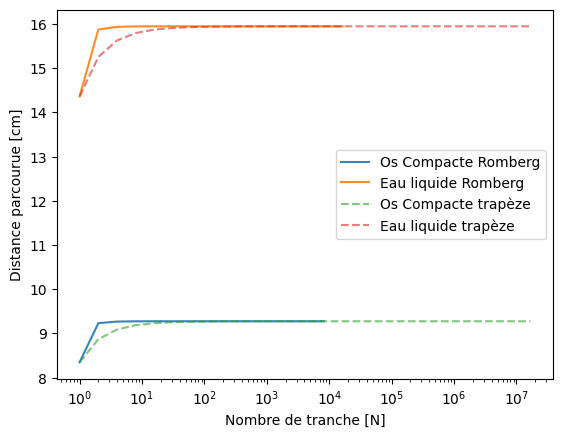

In [138]:
plt.semilogx(*getNRes(Romberg(inverse(SCol_bone), 3, 150, allR=True)), "-",label="Os Compacte Romberg", alpha=0.9)
plt.semilogx(*getNRes(Romberg(inverse(SCol_water), 3, 150, allR=True)), "-",label="Eau liquide Romberg", alpha=0.9)
plt.semilogx(*getNRes(trapz(inverse(SCol_bone), 3, 150, TRY=25,allR=True)), "--",label="Os Compacte trapèze", alpha=0.6)
plt.semilogx(*getNRes(trapz(inverse(SCol_water), 3, 150, TRY=25,allR=True)), "--",label="Eau liquide trapèze", alpha=0.6)

plt.legend()
plt.xlabel("Nombre de tranche [N]")
plt.ylabel("Distance parcourue [cm]")
plt.show()

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Estimation analytique de l'erreur** 
**À faire pour la Q7**

## ***Question 8***
la dérivé de $ S^{-1}_{col}$, selon mon calcul à la main est : $$  \frac{d S^{-1}_{col}}{dT} = \frac{-1}{2\pi r_e^2 m_e c^4 n_e m_p } 
\left( \frac{\left(\frac{-2\gamma^3}{(\gamma^2 - 1)^2} + \frac{2\gamma}{\gamma^2 -1}\right) 
\ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) + \frac{1}{\gamma^2 -1} \left( 4\gamma -\frac{\delta}{b+\delta \gamma}\right) }{\left[ \ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) \frac{\gamma^2}{\gamma^2 -1} -2\right]^2}\right)$$

In [76]:
# Define symbols
T = sp.Symbol('T', real=True, positive=True)  # Temperature
ne = sp.Symbol('n_e', real=True, positive=True)  # Electron number density
IMeV = sp.Symbol('I_{MeV}', real=True, positive=True)  # Ionization energy in MeV
re = sp.Symbol('r_e', real=True, positive=True)  # Classical electron radius
me = sp.Symbol('m_e', real=True, positive=True)  # Electron mass
mp = sp.Symbol('m_p', real=True, positive=True)  # Proton mass
c = sp.Symbol('c', real=True, positive=True)  # Speed of light

# Define gamma factor
gamma = T / (mp * c**2) + 1

# Define T_max
T_max = (2 * me * c**2 * (gamma**2 - 1)) / (1 + 2 * (me / mp) * gamma + (me / mp)**2)

# Define beta
beta = 1 / (gamma**2 / (gamma**2 - 1))

# Define U
U = 2 * sp.pi * re**2 * me * c**2 * ne

# Define S_col expression
S_col = U / (beta**2) * (sp.log((2 * me * c**2 * beta**2 * gamma**2 * T_max) / IMeV**2) - 2 * beta**2)

# Display the expression


In [77]:
f = S_col**-1

In [78]:
f = sp.simplify(f)

In [79]:
dfdT = sp.diff(f,T)

In [80]:
dfdT = sp.together(dfdT)

<hr style="border-color:#D4D4D4">

## ***Question 9***

Rapportez vos portées calulées dans un tableau, qui comprendra aussi les erreurs d’approximation calculées (pour la méthode des trapezes) et évalué de façon pratique (pour la méthode des trapèzes et de Romberg). Il s’agit essentiellement des résultats d́eja obtenus (auxquels on ajoute les erreurs calculées pour la methode des trapèzes). Commentéz vos résultats.


In [ ]:
np.set_printoptions(legacy='1.25')

data_bone_trapeze = pd.read_csv("resultats_bone_trapeze.csv")

N_bone_trapeze = data_bone_trapeze["N"]
I_bone_trapeze = data_bone_trapeze["I (Estimation)"]
erreurs_bone_trapeze = data_bone_trapeze["Erreur"]

data_eau_trapeze = pd.read_csv("resultats_water_trapeze.csv")

N_eau_trapeze = data_eau_trapeze["N"]
I_eau_trapeze = data_eau_trapeze["I (Estimation)"]
erreur_eau_trapeze = data_eau_trapeze["Erreur"]

N_eau_romberg, I_eau_romberg, erreurs_eau_romberg = romberg_avec_erreur(inverse_scol_water, 3, 150, n_values=n_valeurs(), err_toléré=np.finfo(float).eps)

n_bone_romberg, I_bone_romberg, erreurs_bone_romberg = romberg_avec_erreur(inverse_scol_bone, 3, 150, n_values=n_valeurs(), err_toléré=np.finfo(float).eps)

eau_trapeze = {
    "N": N_eau_trapeze,
    "I (Estimation)": I_eau_trapeze,
    "Erreur": erreur_eau_trapeze
}

eau_romberg = {
    "N": N_eau_romberg,
    "I (Estimation)": I_eau_romberg,
    "Erreur": erreurs_eau_romberg
}

bone_trapeze = {
    "N": N_bone_trapeze,
    "I (Estimation)": I_bone_trapeze,
    "Erreur": erreurs_bone_trapeze
}

bone_romberg = {
    "N": n_bone_romberg,
    "I (Estimation)": I_bone_romberg,
    "Erreur": erreurs_bone_romberg
}

# Trouver la longueur maximale parmi les listes de tous les dictionnaires
longueur_max = max(
    len(eau_trapeze["N"]),
    len(eau_romberg["N"]),
    len(bone_trapeze["N"]),
    len(bone_romberg["N"])
)

# Fonction pour compléter les listes courtes avec des valeurs "-"
def completer_liste(liste, longueur_cible):
    return liste + ["-"] * (longueur_cible - len(liste))

# Liste unique pour les valeurs de N
N_values = completer_liste(list(eau_trapeze["N"]), longueur_max)

# Simplification en utilisant la liste partagée pour les valeurs de 'N'
Dictionnaire = {
    "N": N_values,
    "I (Estimation) eau trapeze": completer_liste(list(eau_trapeze["I (Estimation)"]), longueur_max),
    "Erreur eau trapeze": completer_liste(list(eau_trapeze["Erreur"]), longueur_max),
    "I (Estimation) eau Romberg": completer_liste(list(eau_romberg["I (Estimation)"]), longueur_max),
    "Erreur eau Romberg": completer_liste(list(eau_romberg["Erreur"]), longueur_max),
    "I (Estimation) bone trapeze": completer_liste(list(bone_trapeze["I (Estimation)"]), longueur_max),
    "Erreur bone trapeze": completer_liste(list(bone_trapeze["Erreur"]), longueur_max),
    "I (Estimation) bone Romberg": completer_liste(list(bone_romberg["I (Estimation)"]), longueur_max),
    "Erreur bone Romberg": completer_liste(list(bone_romberg["Erreur"]), longueur_max)
}

# Création du DataFrame à partir du dictionnaire
table_combine = pd.DataFrame(Dictionnaire)

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(12, 6))  # Taille de la figure

# Masquer les axes
ax.axis("off")  # Supprime les bordures et numéros

# Affichage du tableau (ax.table pour matplotlib)
mpl_table = ax.table(
    cellText=table_combine.values,  # Valeurs du DataFrame
    colLabels=table_combine.columns,  # Noms des colonnes
    loc="center",  # Centrer le tableau sur la figure
    cellLoc="center"  # Centrer le contenu des cellules
)

# Ajustement de la figure et du tableau
mpl_table.auto_set_font_size(False)  # Autorise le contrôle de la taille des polices
mpl_table.set_fontsize(10)  # Définir une taille de police
mpl_table.auto_set_column_width(col=list(range(len(table_combine.columns))))  # Ajustement automatique des colonnes

# Afficher la figure
plt.show()


<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Optimisation**
## ***Question 10***

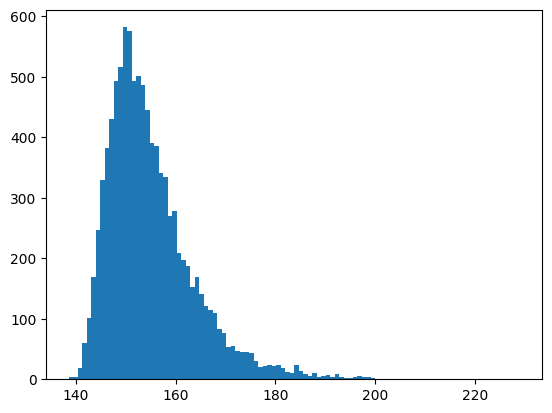

In [81]:
energy_proton = scipy.stats.moyal.rvs(loc=150, scale=4, size=10000)

plt.hist(energy_proton, bins=100)
plt.show()


<hr style="border-color:#D4D4D4">

## ***Question 11***

In [ ]:
I_final_trapeze_water, N_trapeze_water, I_trapeze_water, erreur_trapeze_water = trapeze_avec_erreur(inverse_scol_water, 3, 150, n_valeurs(), 1.49e-8)

I_final_trapeze_bone, N_trapeze_bone, I_trapeze_bone, erreur_trapreze_bone = trapeze_avec_erreur(inverse_scol_bone, 3, 150, n_valeurs(), 1.49e-8)

N_romberg_water, I_romberg_water, erreurs_romberg_water = romberg_avec_erreur(inverse_scol_water, 3, 150, n_values=n_valeurs(), err_toléré=1.49e-8)

N_romberg_bone, I_romberg_bone, erreurs_romberg_bone = romberg_avec_erreur(inverse_scol_bone, 3, 150, n_values=n_valeurs(), err_toléré=1.49e-8)

print(f"La valeurs de N pour trapèze eau liquide pour atteindre la tolérance de Quad est {N_trapeze_water[-1]}")

print(f"La valeurs de N pour trapèze Os compact pour atteindre la tolérance de Quad est {N_trapeze_bone[-1]}")

print(f"La valeurs de N pour romberg eau liquide pour atteindre la tolérance machine est {N_romberg_water[-1]}")

print(f"La valeurs de N pour romberg Os compact pour atteindre la tolérance machine est {N_romberg_bone[-1]}")


In [ ]:
min_value = 3


result_trapeze = np.zeros_like(energy_proton, dtype=float)
result_romberg = np.zeros_like(energy_proton, dtype=float)
result_quad = np.zeros_like(energy_proton, dtype=float)

# Définir un wrapper utilisant scipy.integrate.quad
def quad_method(fc ,energy):
    return integrate.quad(fc, min_value, energy)[0]

# Calcul avec la méthode des trapèzes
def trapeze_method(fc):
    for i, energy in enumerate(energy_proton):
        result_trapeze[i] = trapeze_sans_erreur(fc, 16384, min_value, energy)

# Calcul avec la méthode de Romberg
def romberg_method(fc):
    for i, energy in enumerate(energy_proton):
        result_romberg[i] = romberg_sans_erreur(fc, min_value, energy, 512)


# Calcul avec scipy.integrate.quad
def quad_comp(fc):
    for i, energy in enumerate(energy_proton):
        result_quad[i] = quad_method(fc, energy)


In [ ]:
# Nombre total de protons (énergies)
n_protons = len(energy_proton)

time_trapeze = timeit(lambda: trapeze_method(inverse_scol_water), number=1)
time_romberg = timeit(lambda: romberg_method(inverse_scol_water), number=1)
time_quad = timeit(lambda: quad_comp(inverse_scol_water), number=1)

# Calcul des protons par seconde
protons_per_second_trapeze = n_protons / time_trapeze
protons_per_second_romberg = n_protons / time_romberg
protons_per_second_quad = n_protons / time_quad

# Résultats affichés
print("Temps de calcul et protons par seconde pour eau liquide:")
print(f"Méthode Trapèze : {time_trapeze:.2f} secondes, {protons_per_second_trapeze:.2f} protons/sec")
print(f"Méthode Romberg : {time_romberg:.2f} secondes, {protons_per_second_romberg:.2f} protons/sec")
print(f"SciPy Quad : {time_quad:.2f} secondes, {protons_per_second_quad:.2f} protons/sec")


In [ ]:
# Nombre total de protons (énergies)
n_protons = len(energy_proton)

time_trapeze = timeit(lambda: trapeze_method(inverse_scol_bone), number=1)
time_romberg = timeit(lambda: romberg_method(inverse_scol_bone), number=1)
time_quad = timeit(lambda: quad_comp(inverse_scol_bone), number=1)

# Calcul des protons par seconde
protons_per_second_trapeze = n_protons / time_trapeze
protons_per_second_romberg = n_protons / time_romberg
protons_per_second_quad = n_protons / time_quad

# Résultats affichés
print("Temps de calcul et protons par seconde pour Os Compact:")
print(f"Méthode Trapèze : {time_trapeze:.2f} secondes, {protons_per_second_trapeze:.2f} protons/sec")
print(f"Méthode Romberg : {time_romberg:.2f} secondes, {protons_per_second_romberg:.2f} protons/sec")
print(f"SciPy Quad : {time_quad:.2f} secondes, {protons_per_second_quad:.2f} protons/sec")

<hr style="border-color:#D4D4D4">

## ***Question 12***

<hr style="border-color:#D4D4D4">
<hr style="border-color:#D4D4D4">

# **Énergie déposée**
## ***Question 13***

<hr style="border-color:#D4D4D4">

## ***Question 14***

<hr style="border-color:#D4D4D4">

## ***Question 15***

<hr style="border-color:#D4D4D4">

## ***Question 16***

<hr style="border-color:#D4D4D4">

## ***Question 17***